In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Checking out files: 100% (76/76), done.


In [1]:
%cd drive/MyDrive/Mask_RCNN/

/content/drive/MyDrive/Mask_RCNN


In [ ]:
%pwd

'/content/drive/My Drive/Mask_RCNN'

In [3]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 90kB/s 
     |████████████████████████████████| 491kB 37.7MB/s 
     |████████████████████████████████| 3.2MB 47.6MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [4]:
!pip install tensorflow-gpu==1.14

     |████████████████████████████████| 377.0MB 46kB/s 


In [5]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 15.4MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
#importing all the relevant packages
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# **Training Classifier and Object Detection Models**

In [3]:

class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 6+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [4]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
#Class for ID Card Dataset
class Class1CardDataset(Dataset):

    # load the dataset definitions
    def load_dataset(self, dataset_dir,annot_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "first_name_pkid")
        self.add_class("dataset", 2, "last_name_pkid")
        self.add_class("dataset", 3, "location_pkid")
        self.add_class("dataset", 4, "gender_pkid")
        self.add_class("dataset", 5, "date_of_birth_pkid")
        self.add_class("dataset", 6, "id_pkid")

        
        # define data locations for images and annotations
        images_dir = dataset_dir
        annotations_dir = annot_dir
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id,extt = os.path.splitext(filename)
            test_train=image_id.partition('-')[2]
            dt1=image_id.partition('-')[0]
            test_cond=extt[1:]
            if (len(test_train)>3):
              continue
    
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'

              #print(img_path,ann_path)
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax,name]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if box[4]=='first_name_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('first_name_pkid'))
            elif box[4]=='last_name_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('last_name_pkid'))
            elif box[4]=='location_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('location_pkid'))
            elif box[4]=='gender_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('gender_pkid'))
            elif box[4]=='date_of_birth_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 5
                class_ids.append(self.class_names.index('date_of_birth_pkid'))
            elif box[4]=='id_pkid':
                masks[row_s:row_e, col_s:col_e, i] = 6
                class_ids.append(self.class_names.index('id_pkid'))
           
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path'] 

In [6]:
# prepare train set for ID card
train_set1 = Class1CardDataset()
train_set1.load_dataset('./Final_Dataset/Train/ID/','./Final_Dataset/annots/',is_train=True)
train_set1.prepare()
print('Train: %d' % len(train_set1.image_ids))

# prepare test/val set for ID card
test_set1 = Class1CardDataset()
test_set1.load_dataset('./Final_Dataset/Test/ID/','./Final_Dataset/annots/', is_train=False)
test_set1.prepare()
print('Test: %d' % len(test_set1.image_ids))

Train: 5759
Test: 1440


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# Training for object detection of ID card
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=60, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./maskrcnn_config20201227T1206/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du

Epoch 1/60
130/131 [============================>.] - ETA: 0s - loss: 1.1636 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.4185 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.2476

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 128s - loss: 1.1695 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4197 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2484 - val_loss: 1.0510 - val_rpn_class_loss: 0.0194 - val_rpn_bbox_loss: 0.3509 - val_mrcnn_class_loss: 0.2264 - val_mrcnn_bbox_loss: 0.2087 - val_mrcnn_mask_loss: 0.2456
Epoch 2/60
131/131 [==============================] - 108s - loss: 1.0704 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.3700 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2440 - val_loss: 1.0370 - val_rpn_class_loss: 0.0407 - val_rpn_bbox_loss: 0.3259 - val_mrcnn_class_loss: 0.2561 - val_mrcnn_bbox_loss: 0.1907 - val_mrcnn_mask_loss: 0.2235
Epoch 3/60
131/131 [==============================] - 106s - loss: 1.1261 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.2466 - val_loss: 1.3753 - val_rpn_class_loss: 0.0413 - val_rpn_bbox_loss: 0.

In [ ]:
model_path = 'PakId_60Epochs' + '.h5'
model.keras_model.save_weights(model_path)

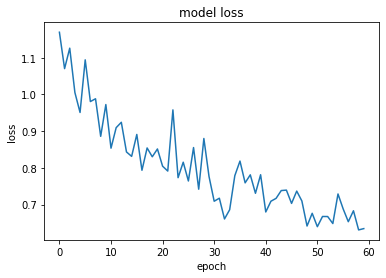

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [5]:
# Class for evaluating MAP for object detection model
from mrcnn.utils import compute_ap
class EvalImage():
  def __init__(self,dataset,model,cfg):
    self.dataset = dataset
    self.model   = model
    self.cfg     = cfg

 
 
  def evaluate_model(self , len = 50):
    APs = list()
    precisions_dict = {}
    recall_dict     = {}
    for index,image_id in enumerate(self.dataset.image_ids):
      if(index > len):
         break; 
      # load image, bounding boxes and masks for the image id
      image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(self.dataset, self.cfg,image_id, use_mini_mask=False)
      # convert pixel values (e.g. center)
      #scaled_image = modellib.mold_image(image, self.cfg)
      # convert image into one sample
      sample = np.expand_dims(image, 0)
     # print(len(image))
      # make prediction
      yhat = self.model.detect(sample, verbose=1)
      # extract results for first sample
      r = yhat[0]
      # calculate statistics, including AP
      AP, precisions, recalls, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
      precisions_dict[image_id] = np.mean(precisions)
      recall_dict[image_id] = np.mean(recalls)
      # store
      APs.append(AP)

    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP,precisions_dict,recall_dict

In [ ]:
eval = EvalImage(test_set,model,config)
map,pr,re=eval.evaluate_model(200)

In [ ]:
print('Mean Average Precision:',map)

Mean Average Precision: 0.935984758594623


In [7]:
# Dataset class for Passport
class Class2CardDataset(Dataset):

    # load the dataset definitions
    def load_dataset(self, dataset_dir,annot_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "first_name_pkpass")
        self.add_class("dataset", 2, "last_name_pkpass")
        self.add_class("dataset", 3, "location_pkpass")
        self.add_class("dataset", 4, "gender_pkpass")
        self.add_class("dataset", 5, "date_of_birth_pkpass")
        self.add_class("dataset", 6, "id_pkpass")

        
        # define data locations for images and annotations
        images_dir = dataset_dir
        annotations_dir = annot_dir
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):

          # extract image id
          image_id,extt = os.path.splitext(filename)
          #print(image_id)
          test_train=image_id.partition('-')[2]
          dt1=image_id.partition('-')[0]
          test_cond=extt[1:]
          if (len(test_train)>3):
            continue

            
            
            # setting image file
          img_path = images_dir + filename
            
            # setting annotations file
          ann_path = annotations_dir + image_id + '.xml'

              #print(img_path,ann_path)
            
            # adding images and annotations to dataset
          self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax,name]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if box[4]=='first_name_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('first_name_pkpass'))
            elif box[4]=='last_name_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('last_name_pkpass'))
            elif box[4]=='location_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('location_pkpass'))
            elif box[4]=='gender_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('gender_pkpass'))
            elif box[4]=='date_of_birth_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 5
                class_ids.append(self.class_names.index('date_of_birth_pkpass'))
            elif box[4]=='id_pkpass':
                masks[row_s:row_e, col_s:col_e, i] = 6
                class_ids.append(self.class_names.index('id_pkpass'))
           
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path'] 

In [8]:
# prepare train set for passport
train_set2 = Class2CardDataset()
train_set2.load_dataset('./Final_Dataset/Train/Pass/','./Final_Dataset/annots/',is_train=True)
train_set2.prepare()
print('Train: %d' % len(train_set2.image_ids))

# prepare test/val set for passport
test_set2 = Class2CardDataset()
test_set2.load_dataset('./Final_Dataset/Test/Pass/','./Final_Dataset/annots/', is_train=False)
test_set2.prepare()
print('Test: %d' % len(test_set2.image_ids))

Train: 6000
Test: 1500


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...


In [ ]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# Object detection training for Passports
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=60, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./maskrcnn_config20201227T1506/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du

Epoch 1/60
130/131 [============================>.] - ETA: 0s - loss: 2.5187 - rpn_class_loss: 0.2063 - rpn_bbox_loss: 0.8287 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.6850 - mrcnn_mask_loss: 0.4565

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 276s - loss: 2.5105 - rpn_class_loss: 0.2054 - rpn_bbox_loss: 0.8260 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.6827 - mrcnn_mask_loss: 0.4557 - val_loss: 1.9305 - val_rpn_class_loss: 0.0953 - val_rpn_bbox_loss: 0.6463 - val_mrcnn_class_loss: 0.3637 - val_mrcnn_bbox_loss: 0.4675 - val_mrcnn_mask_loss: 0.3577
Epoch 2/60
131/131 [==============================] - 117s - loss: 1.8527 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 0.7007 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.3162 - val_loss: 1.8325 - val_rpn_class_loss: 0.0980 - val_rpn_bbox_loss: 0.7590 - val_mrcnn_class_loss: 0.2597 - val_mrcnn_bbox_loss: 0.3591 - val_mrcnn_mask_loss: 0.3567
Epoch 3/60
131/131 [==============================] - 112s - loss: 1.7418 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 0.6643 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.3096 - val_loss: 1.5857 - val_rpn_class_loss: 0.0701 - val_rpn_bbox_loss: 0.

In [ ]:
model_path = 'PakPass_60Epochs' + '.h5'
model.keras_model.save_weights(model_path)

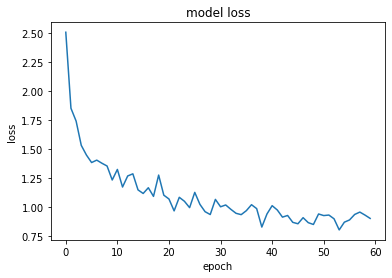

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
eval = EvalImage(test_set,model,config)
map,pr,re=eval.evaluate_model(200)

In [11]:
print('Mean Average Precision:',map)

Mean Average Precision: 0.895891573741852


In [ ]:
# Preprocessing the Training and Test set for Binary Classifier
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('Final_Dataset/Train/',
                                                 target_size = (150,150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 11786 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('Final_Dataset/Test/',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2949 images belonging to 2 classes.


In [ ]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Activation('relu'))

# Output layer with single neuron which gives 0 for ID card or 1 for Passport 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Training for Binary Classifier
classifier=model.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
369/369 [==============================] - 3946s 11s/step - loss: 0.2061 - acc: 0.9098 - val_loss: 0.1197 - val_acc: 0.9651
Epoch 2/15
369/369 [==============================] - 205s 555ms/step - loss: 0.0647 - acc: 0.9790 - val_loss: 0.0391 - val_acc: 0.9885
Epoch 3/15
369/369 [==============================] - 201s 546ms/step - loss: 0.0387 - acc: 0.9871 - val_loss: 0.0119 - val_acc: 0.9956
Epoch 4/15
369/369 [==============================] - 202s 547ms/step - loss: 0.0388 - acc: 0.9879 - val_loss: 0.0713 - val_acc: 0.9800
Epoch 5/15
369/369 [==============================] - 200s 543ms/step - loss: 0.0317 - acc: 0.9902 - val_loss: 0.0207 - val_acc: 0.9963
Epoch 6/15
369/369 [==============================] - 199s 540ms/step - loss: 0.0354 - acc: 0.9895 - val_loss: 0.0228 - val_acc: 0.9905
Epoch 7/15
369/369 [==============================] - 198s 537ms/step - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0274 - val_acc: 0.9915
Epoch 8/15
369/369 [=============================

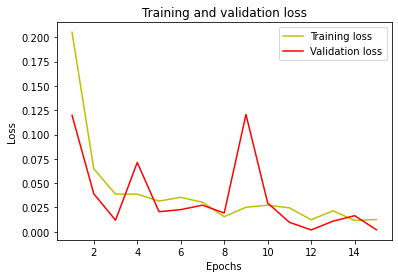

In [ ]:
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

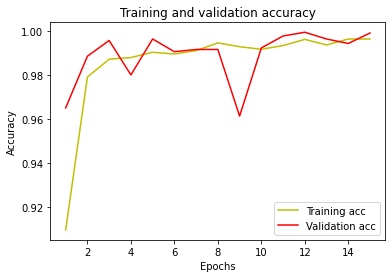

In [ ]:
acc = classifier.history['acc']
val_acc = classifier.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Function for predicting the class of image
def predictImage(filename,model):
    img1 = image.load_img(filename,target_size=(150,150))
    img2 = image.load_img(filename)
    plt.imshow(img2)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("PASSPORT",fontsize=30)
        return 1
        
    
    elif val == 0:
        
        plt.xlabel("ID CARD",fontsize=30)
        return 0

In [ ]:
model.save("Final_Classifier.h5")
print("Saved model to disk")

Saved model to disk


# **Predicting from Trained Models**

In [9]:
# Detecting Part
# Loading the trained Biinary Classifier
binary_classifier = keras.models.load_model ("Final_Classifier.h5") 
# summarize model.
binary_classifier.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_

In [10]:
# Loading trained object detection model for ID cards
#Loading the model in the inference mode
model1 = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model1.load_weights('PakId_60Epochs.h5', by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [11]:
# Loading trained object detection model for Passports
#Loading the model in the inference mode
model2 = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model2.load_weights('PakPass_60Epochs.h5', by_name=True)

In [12]:
# Path to the image we are going to detect
imgpath='Final_Dataset/Test/ID/23-250.jpg'

[[0.]]


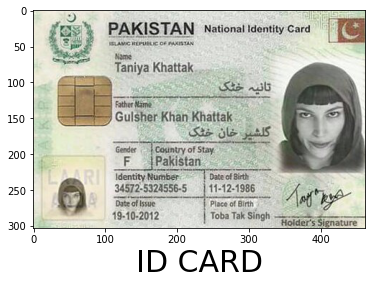

In [15]:
# Predicting class type of image as ID or Passport
class_type=predictImage(imgpath,binary_classifier)

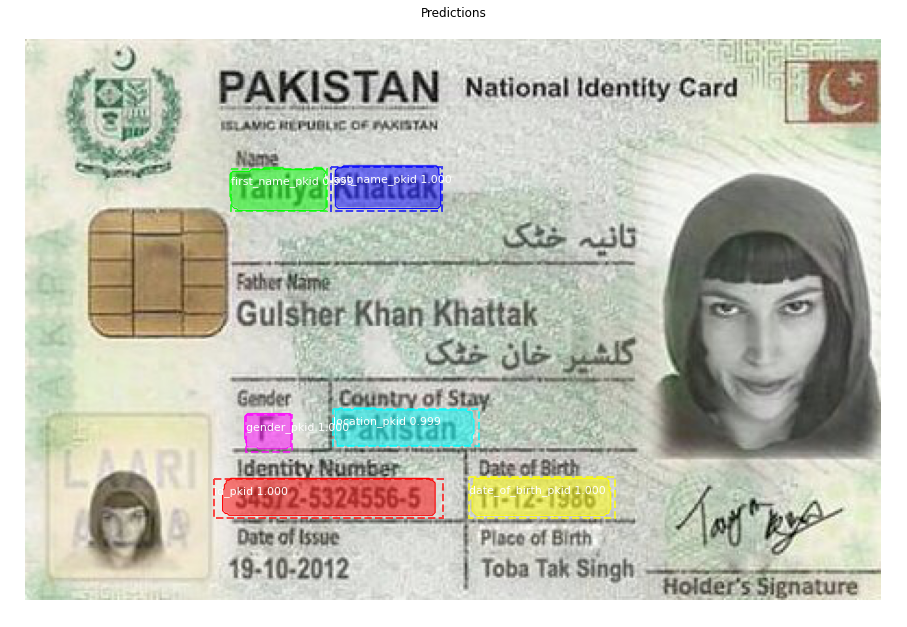

In [16]:
#Performing object detection depending on class of image
if class_type==0:
  img = load_img(imgpath)
  img = img_to_array(img)# detecting objects in the image
  result= model1.detect([img])
  r = result[0]
  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            test_set1.class_names, r['scores'], 
                            title="Predictions")
else:
  img = load_img(imgpath)
  img = img_to_array(img)# detecting objects in the image
  result= model2.detect([img])
  r = result[0]
  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            test_set2.class_names, r['scores'], 
                            title="Predictions")
